In [1]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles


sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_dask import create_local_dask_cluster
from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag

dc = datacube.Datacube(app='Animated timeseries' )


%load_ext autoreload
%autoreload 2

In [2]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [3]:
# bands=['nbar_red', 'nbar_green', 'nbar_blue']
bands=['nbar_swir_1', 'nbar_nir', 'nbar_green']

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': ('1987', '2020'),
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
}

ds_ls = load_ard(dc=dc,
                 products=[
                           'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 
#                            'ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule', 
#                            's2a_nrt_granule', 's2b_nrt_granule'
                          ],
                 min_gooddata=0.9,
                 ls7_slc_off=False,
                 mask_pixel_quality=True,
                 **query)


ds_ls = tidal_tag(ds_ls)
ds_ls = ds_ls.sel(time = ds_ls.tide_height < ds_ls.tide_height.median())
ds_ls = ds_ls.compute()
ds_ls


# dss_ls5 = dc.find_datasets(product='ls5_nbart_geomedian_annual', **query)
# dss_ls7 = dc.find_datasets(product='ls7_nbart_geomedian_annual', **query)
# dss_ls8 = dc.find_datasets(product='ls8_nbart_geomedian_annual', **query)
# dss = dss_ls5 + dss_ls7 + dss_ls8

# ds = dc.load(datasets=dss,
#              measurements=['red', 'green', 'blue'],
#              output_crs='EPSG:3577',
#              resolution=(-30, 30),
#              **query)
# ds


Client Scheduler: tcp://127.0.0.1:46581 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


../../Scripts/dea_datahandling.py:227: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step


tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='app.sandbox.dea.ga.gov.au', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/env/lib/python3.6/site-packages/tornado/websocket.py", line 956, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "/env/lib/python3.6/site-packages/bokeh/server/views/ws.py", line 123, in open
    raise ProtocolError("Subprotocol header is not 'bokeh'")
bokeh.protocol.exceptions.ProtocolError: Subprotocol header is not 'bokeh'


Filtering to 409 out of 569 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 409 time steps as a dask array
Setting tide modelling location from dataset centroid: 129.87, -15.42


ValueError: Tides could not be modelled for dataset centroid located at 129.87, -15.42. This can occur if this coordinate occurs over land. Please manually specify a tide modelling location located over water using the `tidepost_lat` and `tidepost_lon` parameters.

In [4]:
ds_ls = ds_ls.compute()
ds_ls

<xarray.Dataset>
Dimensions:      (time: 409, x: 611, y: 416)
Coordinates:
  * time         (time) datetime64[ns] 1987-05-30T00:48:11.192689 ... 2019-06-07T01:23:45.995167
  * y            (y) float64 -1.699e+06 -1.699e+06 ... -1.711e+06 -1.711e+06
  * x            (x) float64 5.845e+05 5.845e+05 ... 6.028e+05 6.028e+05
Data variables:
    nbar_swir_1  (time, y, x) float32 2790.0 2862.0 2717.0 ... 2765.0 2818.0
    nbar_nir     (time, y, x) float32 2802.0 2854.0 2802.0 ... 2281.0 2251.0
    nbar_green   (time, y, x) float32 1163.0 1115.0 1115.0 ... 831.0 788.0 805.0
Attributes:
    crs:      epsg:32652

In [5]:
ds_rolling = ds_ls.rolling(time=40, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
ds_rolling

<xarray.Dataset>
Dimensions:      (time: 409, x: 611, y: 416)
Coordinates:
  * time         (time) datetime64[ns] 1987-05-30T00:48:11.192689 ... 2019-06-07T01:23:45.995167
  * y            (y) float64 -1.699e+06 -1.699e+06 ... -1.711e+06 -1.711e+06
  * x            (x) float64 5.845e+05 5.845e+05 ... 6.028e+05 6.028e+05
Data variables:
    nbar_swir_1  (time, y, x) float32 2685.5 2746.0 2738.0 ... 2974.0 2881.0
    nbar_nir     (time, y, x) float32 2313.5 2332.0 2422.0 ... 2553.0 2538.0
    nbar_green   (time, y, x) float32 1040.5 1044.0 1054.5 ... 913.0 868.0 849.0

In [ ]:
# import geopandas as gpd
# import pandas as pd
# import matplotlib

# overlay_gdf = gpd.read_file('example2.geojson')
# overlay_gdf = overlay_gdf.dissolve('year')

# norm = matplotlib.colors.Normalize(vmin=0, vmax=len(overlay_gdf.index))
# cmap = matplotlib.cm.get_cmap('YlOrRd')
# rgba = cmap(norm(overlay_gdf.reset_index().index))
# overlay_gdf['color'] = list(rgba)
# overlay_gdf['start_time'] = pd.to_datetime(overlay_gdf.index) 
# overlay_gdf.head()

Applying custom image processing functions


Exporting animation to animation.mp4


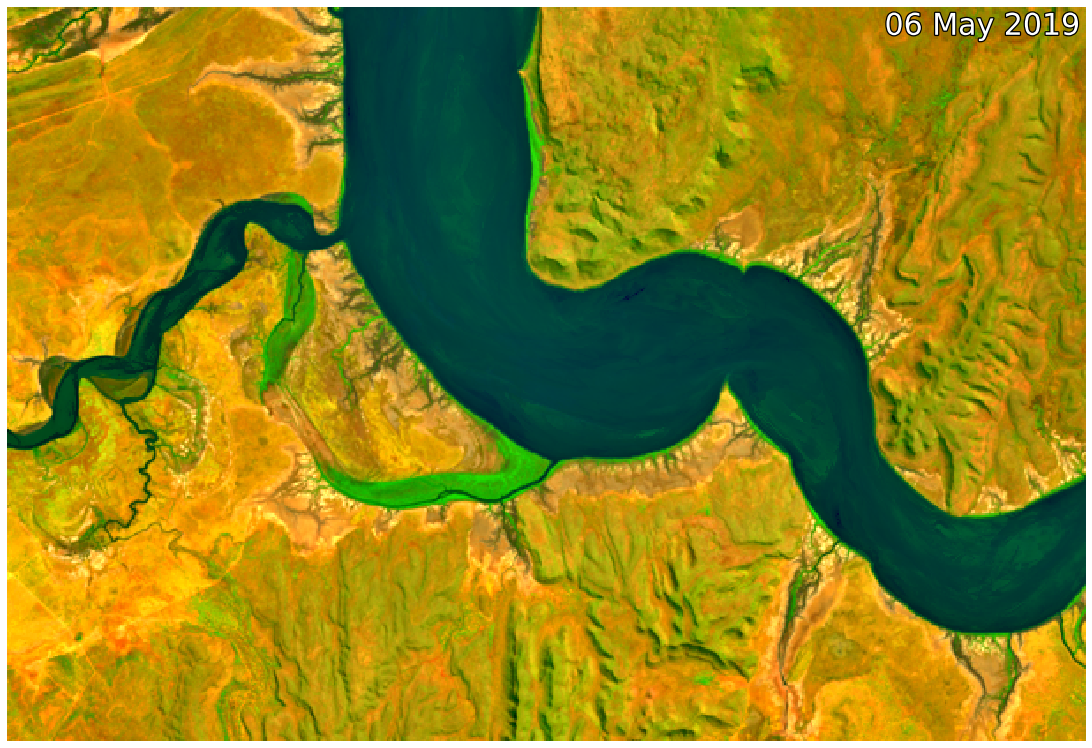

In [7]:
import numpy as np
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#               lambda x: x**0.15,
              rescale_intensity,
              lambda x: unsharp_mask(x, radius=50, amount=0.5),
              lambda x: unsharp_mask(x, radius=5, amount=0.2),
             ]
# funcs_list = None

xr_animation(ds=ds_rolling.isel(time=slice(5, -2)),
             bands=bands,
             interval=70,
             width_pixels=1080,
             percentile_stretch=(0.02, 0.98),
             image_proc_funcs=funcs_list,
             annotation_kwargs={'fontsize': 30},
#              limit=20,
            ) 